<a href="https://colab.research.google.com/github/u17095736-coder/Part--2-MIT-805-Assignment/blob/main/MIT_805_Merhawi_Hailu_Road_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dependencies

In [ ]:
!pip -q install kagglehub pyspark ultralytics pillow pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.9 MB/s eta 0:00:00


Libraries

In [ ]:
import os, re, io, shutil, hashlib, math, random, json
from pathlib import Path
from typing import Tuple, List, Dict
import xml.etree.ElementTree as ET

import numpy as np
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

from ultralytics import YOLO
print("Versions -> pyspark:", pyspark.__version__)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Versions -> pyspark: 3.5.1


Datatset

In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download("nomihsa965/traffic-signs-dataset-mapillary-and-dfg")
print("Dataset downloaded to:", dataset_path)

root = Path(dataset_path)
all_xml = list(root.rglob("*.xml"))
all_imgs = list(root.rglob("*.jpg")) + list(root.rglob("*.png"))
print(f"Found {len(all_xml)} XML files and {len(all_imgs)} images.")


100%|██████████| 11.6G/11.6G [02:25<00:00, 85.8MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/nomihsa965/traffic-signs-dataset-mapillary-and-dfg/versions/1
Found 19346 XML files and 49905 images.


Initialization Spark Session

In [ ]:
spark = (
    SparkSession.builder
    .appName("TrafficSign-MapReduce")
    .config("spark.ui.showConsoleProgress", "true")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("WARN")
print(spark)


Distributed Parsing and Mapping +  Filtering and cleaning

In [ ]:
def parse_xml_to_records(xml_path: str) -> List[Tuple[str, dict]]:
    out = []
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        image_filename = root.findtext('filename')
        if not image_filename:
            return out
        iw = int(root.findtext('size/width') or 0)
        ih = int(root.findtext('size/height') or 0)
        for obj in root.findall('object'):
            name = obj.findtext('name') or "unknown"
            bb = obj.find('bndbox')
            if bb is None:
                continue
            xmin = int(float(bb.findtext('xmin') or 0))
            ymin = int(float(bb.findtext('ymin') or 0))
            xmax = int(float(bb.findtext('xmax') or 0))
            ymax = int(float(bb.findtext('ymax') or 0))
            rec = {"cls": name.strip(), "bbox": (xmin, ymin, xmax, ymax),
                   "image_filename": image_filename, "image_wh": (iw, ih), "xml_path": xml_path}
            out.append((image_filename, rec))
    except Exception:
        pass
    return out

xml_files = [str(p) for p in Path(dataset_path).rglob("*.xml")]
rdd = sc.parallelize(xml_files, numSlices=max(8, sc.defaultParallelism)).flatMap(parse_xml_to_records)

def valid_rec(kv):
    _, rec = kv
    xmin, ymin, xmax, ymax = rec["bbox"]
    iw, ih = rec["image_wh"]
    return (iw > 0 and ih > 0 and 0 <= xmin < xmax <= iw and 0 <= ymin < ymax <= ih)

records_rdd = rdd.filter(valid_rec).cache()
print("Total valid instances:", records_rdd.count())
print("Example:", records_rdd.take(1)[:1])


Total valid instances: 30557
Example: [('WET9tCPf20RUFaVDAwf9ag.jpg', {'cls': 'regulatory--no-parking', 'bbox': (1466, 306, 1511, 356), 'image_filename': 'WET9tCPf20RUFaVDAwf9ag.jpg', 'image_wh': (2592, 1944), 'xml_path': '/root/.cache/kagglehub/datasets/nomihsa965/traffic-signs-dataset-mapillary-and-dfg/versions/1/xmls/WET9tCPf20RUFaVDAwf9ag.xml'})]


Aggregation

In [ ]:
class_counts = (
    records_rdd
    .map(lambda kv: (kv[1]["cls"], 1))
    .reduceByKey(lambda a, b: a + b)
    .collect()
)
pd.DataFrame(sorted(class_counts, key=lambda x: x[1], reverse=True), columns=["class", "count"]).head(20)


,class,count
0,regulatory--maximum-speed-limit,3719
1,regulatory--yield,1675
2,information--parking,1156
3,regulatory--no-entry,1023
4,regulatory--stop,967
5,regulatory--shared-path-pedestrians-and-bicycles,811
6,regulatory--keep-right,727
7,complementary--chevron-left,509
8,warning--pedestrians-crossing,465
9,regulatory--height-limit,462


In [ ]:
img_lookup = {imgp.name: str(imgp)
              for imgp in (list(Path(dataset_path).rglob("*.jpg")) + list(Path(dataset_path).rglob("*.png")))}
img_lookup_bc = sc.broadcast(img_lookup)

def attach_image_path(kv):
    key, rec = kv
    img_path = img_lookup_bc.value.get(key)
    if img_path is None:
        return None
    rec2 = dict(rec)
    rec2["img_path"] = img_path
    return (key, rec2)

with_paths_rdd = records_rdd.map(attach_image_path).filter(lambda x: x is not None).cache()
print("Instances with image paths:", with_paths_rdd.count())


Instances with image paths: 30557


In [ ]:
def split_from_key(key: str, train=0.70, val=0.15, test=0.15):
    h = hashlib.md5(key.encode('utf-8')).hexdigest()
    r = int(h[:8], 16) / 0xFFFFFFFF
    if r < train:
        return "train"
    elif r < train + val:
        return "val"
    else:
        return "test"

with_splits_rdd = with_paths_rdd.map(lambda kv: (kv[0], {**kv[1], "split": split_from_key(kv[0])})).cache()
split_counts = with_splits_rdd.map(lambda kv: (kv[1]["split"], 1)).reduceByKey(lambda a,b: a+b).collect()
split_counts


[('val', 4589), ('test', 4718), ('train', 21250)]

Distributed Image Cropping (Map partition phase)

In [ ]:
base_dir = Path("./data_cls")
for sub in ["train", "val", "test"]:
    (base_dir / sub).mkdir(parents=True, exist_ok=True)

def safe_class_name(s: str) -> str:
    s = re.sub(r"[^a-zA-Z0-9._-]+", "_", s.strip())
    return s[:64] if s else "unknown"

def crop_and_save_partition(iter_kv):
    from PIL import Image
    import os, hashlib
    base = Path("./data_cls")
    saved = 0
    for key, rec in iter_kv:
        try:
            img_path = rec["img_path"]
            cls_name = safe_class_name(rec["cls"])
            split = rec["split"]
            xmin, ymin, xmax, ymax = rec["bbox"]
            with Image.open(img_path) as im:
                crop = im.crop((xmin, ymin, xmax, ymax)).convert("RGB")
                crop = crop.resize((224, 224))
                fid = hashlib.md5(f"{os.path.basename(img_path)}-{xmin}-{ymin}-{xmax}-{ymax}".encode()).hexdigest()[:12]
                out_dir = base / split / cls_name
                out_dir.mkdir(parents=True, exist_ok=True)
                out_path = out_dir / f"{fid}.jpg"
                crop.save(out_path, format="JPEG", quality=90)
                saved += 1
        except Exception:
            continue
    yield saved

saved_counts = with_splits_rdd.mapPartitions(crop_and_save_partition).collect()
{"per_partition": saved_counts, "total": int(sum(saved_counts))}


{'per_partition': [3247, 3235, 4789, 3200, 3229, 4860, 3214, 4783],
 'total': 30557}

In [ ]:
def list_jpegs_under(p: Path):
    return [str(q) for q in p.rglob("*.jpg")]

train_files = sc.parallelize(list_jpegs_under(base_dir / "train"), numSlices=8)
val_files   = sc.parallelize(list_jpegs_under(base_dir / "val"), numSlices=8)
test_files  = sc.parallelize(list_jpegs_under(base_dir / "test"), numSlices=8)

def class_from_path(p: str) -> str:
    return Path(p).parent.name

def to_one(p):
    return (class_from_path(p), 1)

def counts(rdd):
    return dict(rdd.map(to_one).reduceByKey(lambda a,b: a+b).collect())

dist = {
    "train": counts(train_files),
    "val": counts(val_files),
    "test": counts(test_files)
}
pd.DataFrame.from_dict(dist, orient="index").fillna(0).astype(int).T.sort_index().head(20)


,train,val,test
complementary--chevron-left,357,76,76
complementary--chevron-right,228,54,49
complementary--distance,253,49,68
information--disabled-persons,211,51,33
information--gas-station,170,38,23
information--hospital,133,30,34
information--motorway,229,54,44
information--parking,795,160,201
information--tram-bus-stop,115,24,17
regulatory--axel-mass-limit,159,21,34


MapReduce Visualization

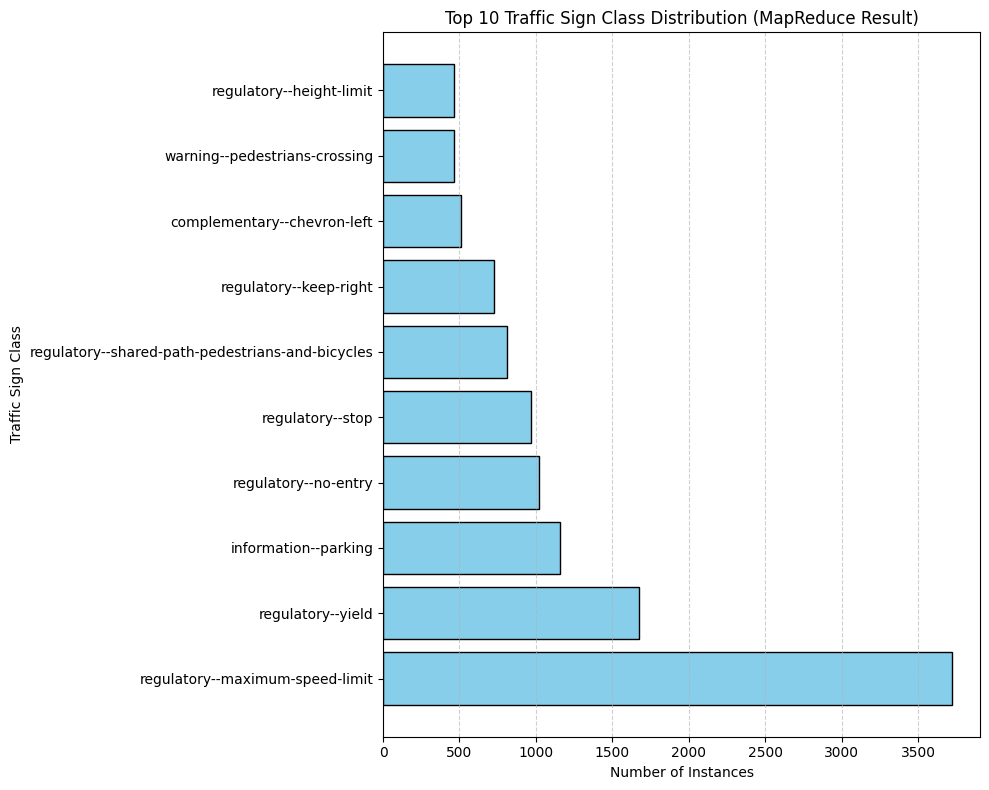

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


class_counts_data = {
    "class": [
        "regulatory--maximum-speed-limit", "regulatory--yield", "information--parking",
        "regulatory--no-entry", "regulatory--stop", "regulatory--shared-path-pedestrians-and-bicycles",
        "regulatory--keep-right", "complementary--chevron-left", "warning--pedestrians-crossing",
        "regulatory--height-limit", "warning--roadworks", "regulatory--no-overtaking",
        "regulatory--turn-right", "warning--road-bump", "warning--other-danger",
        "regulatory--no-heavy-goods-vehicles", "regulatory--no-left-turn", "regulatory--no-right-turn",
        "regulatory--keep-left", "regulatory--roundabout"
    ],
    "count": [
        3719, 1675, 1156, 1023, 967, 811, 727, 509, 465, 462,
        450, 439, 437, 433, 432, 426, 419, 405, 397, 391
    ]
}

df_class_counts = pd.DataFrame(class_counts_data)


df_top_10 = df_class_counts.sort_values(by='count', ascending=False).head(10)
df_top_10 = df_top_10.sort_values(by='count', ascending=True)  # For horizontal bar chart


plt.figure(figsize=(10, 8))
plt.barh(df_top_10['class'], df_top_10['count'], color='skyblue', edgecolor='black')
plt.xlabel('Number of Instances')
plt.ylabel('Traffic Sign Class')
plt.title('Top 10 Traffic Sign Class Distribution (MapReduce Result)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('top_10_class_distribution.png')
plt.show()


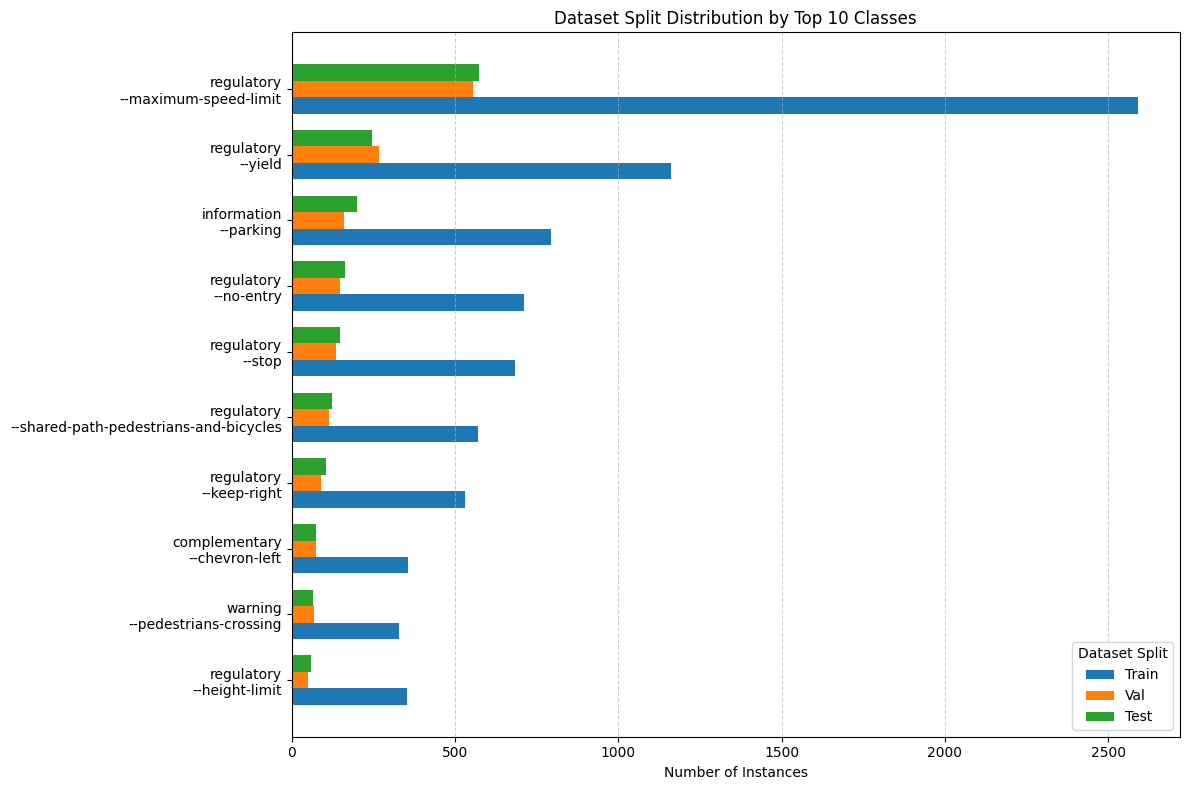

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


data = {
    "class": [
        "regulatory--maximum-speed-limit", "regulatory--yield", "information--parking",
        "regulatory--no-entry", "regulatory--stop", "regulatory--shared-path-pedestrians-and-bicycles",
        "regulatory--keep-right", "complementary--chevron-left", "warning--pedestrians-crossing",
        "regulatory--height-limit"
    ],
    "train": [2590, 1160, 795, 711, 684, 572, 531, 357, 330, 354],
    "val": [556, 269, 160, 148, 136, 114, 90, 76, 69, 49],
    "test": [573, 246, 201, 164, 147, 125, 106, 76, 66, 59]
}

df_split = pd.DataFrame(data).set_index('class')
top_classes_reversed = df_split.index[::-1]
bar_width = 0.25
indices = np.arange(len(top_classes_reversed))

fig, ax = plt.subplots(figsize=(12, 8))

splits = ['train', 'val', 'test']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, split in enumerate(splits):
    counts = df_split.loc[top_classes_reversed, split]
    ax.barh(indices + i * bar_width, counts, bar_width, label=split.capitalize(), color=colors[i])

ax.set_yticks(indices + bar_width)
ax.set_yticklabels([cls.replace('--', '\n--') for cls in top_classes_reversed])
ax.set_xlabel('Number of Instances')
ax.set_title('Dataset Split Distribution by Top 10 Classes')
ax.legend(title='Dataset Split')
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

YOLO Machine Learning Training

In [ ]:
data_root = str(base_dir.resolve())
model = YOLO('yolov8n-cls.pt')
results = model.train(data=data_root, epochs=5, imgsz=224, device='cpu')
"Training complete"


Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_cls, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

'Training complete'

In [ ]:
val_metrics = model.val(data=data_root, split='val', imgsz=224, device='cpu')
test_metrics = model.val(data=data_root, split='test', imgsz=224, device='cpu')
{"val": val_metrics.results_dict, "test": test_metrics.results_dict}


Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,532,236 parameters, 0 gradients, 3.4 GFLOPs
train: /content/data_cls/train... found 21250 images in 76 classes ✅ 
val: /content/data_cls/val... found 4589 images in 76 classes ✅ 
test: /content/data_cls/test... found 4718 images in 76 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 249.3±105.4 MB/s, size: 8.7 KB)
val: Scanning /content/data_cls/val... 4589 images, 0 corrupt: 100% ━━━━━━━━━━━━ 4589/4589 3.5Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 287/287 3.8it/s 1:15
                   all      0.865      0.997
Speed: 0.0ms preprocess, 13.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val
Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
train: /content/data_cls/train... found 21250 images in 76 classes ✅ 
val: /content/data_cls/val

{'val': {'metrics/accuracy_top1': 0.8648943305015564,
  'metrics/accuracy_top5': 0.9969492554664612,
  'fitness': 0.9309217929840088},
 'test': {'metrics/accuracy_top1': 0.865621030330658,
  'metrics/accuracy_top5': 0.9959728717803955,
  'fitness': 0.9307969510555267}}

In [ ]:
sample = test_files.takeSample(False, 3) if test_files.count() >= 3 else train_files.takeSample(False, 3)
pred = model.predict(sample, imgsz=224, device='cpu')
pred[:2]



0: 224x224 warning--crossroads 0.96, warning--junction-with-a-side-road-perpendicular-left 0.02, warning--junction-with-a-side-road-perpendicular-right 0.02, warning--road-narrows 0.00, warning--double-curve-first-right 0.00, 16.8ms
1: 224x224 regulatory--maximum-speed-limit 0.94, regulatory--weight-limit 0.02, complementary--distance 0.01, regulatory--stop 0.00, regulatory--no-parking 0.00, 16.8ms
2: 224x224 regulatory--maximum-speed-limit 0.99, regulatory--weight-limit 0.00, regulatory--height-limit 0.00, regulatory--no-parking 0.00, regulatory--yield-to-oncoming-traffic 0.00, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 masks: None
 names: {0: 'complementary--chevron-left', 1: 'complementary--chevron-right', 2: 'complementary--distance', 3: 'information--disabled-persons', 4: 'information--gas-station', 5: 'information--hospital', 6: 'information--motorway', 7: 'information--parking', 8: 'information--tram-bus-stop', 9: 'regulatory--axel-mass-limit', 10: 'regulatory--bicycles-only', 11: 'regulatory--go-straight', 12: 'regulatory--go-straight-or-turn-left', 13: 'regulatory--go-straight-or-turn-right', 14: 'regulatory--height-limit', 15: 'regulatory--keep-left', 16: 'regulatory--keep-right', 17: 'regulatory--maximum-speed-limit', 18: 'regulatory--no-bicycles', 19: 'regulatory--no-buses', 20: 'regulatory--no-entry', 21: 'regulatory--no-goods-vehicles', 22: 'regulatory--no-goods-vehicles-exceeding-limit', 23: 'regulatory--no-heavy-goods-vehicles', 24: 'regulatory--no-left-turn', 25: 'regulatory--no-motor-vehicles'

In [ ]:
out_dir = Path("./artifacts")
out_dir.mkdir(exist_ok=True, parents=True)
last_run = sorted(Path("runs/classify").glob("train*"))[-1] if Path("runs/classify").exists() else None
run_info = {
    "data_root": str(Path("./data_cls").resolve()),
    "last_run": str(last_run) if last_run else None
}
with open(out_dir / "run_info.json", "w") as f:
    json.dump(run_info, f, indent=2)
run_info


{'data_root': '/content/data_cls', 'last_run': 'runs/classify/train'}

Visualization for Machine Learning Result (YOLO8)

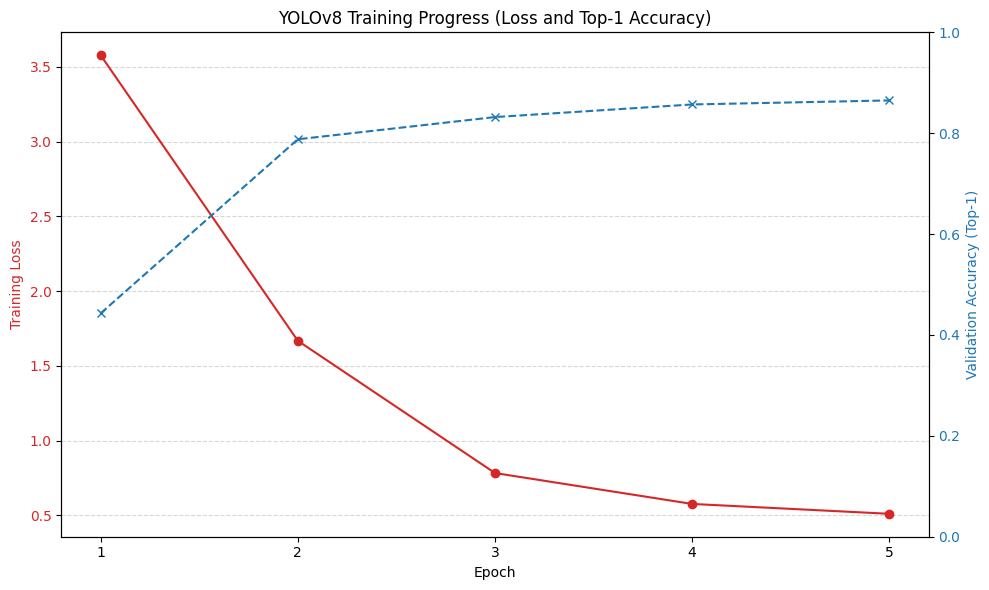

<Figure size 800x600 with 0 Axes>

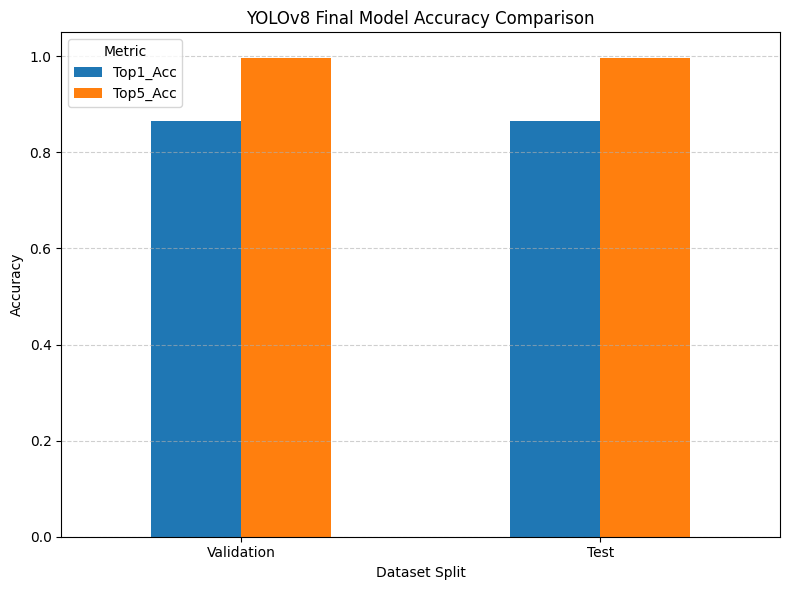

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Loss': [3.577, 1.667, 0.7825, 0.5758, 0.5099],
    'Top1_Acc': [0.443, 0.788, 0.832, 0.857, 0.865],
    'Top5_Acc': [0.762, 0.983, 0.993, 0.996, 0.997]
}
df_training = pd.DataFrame(data)


fig, ax1 = plt.subplots(figsize=(10, 6))


color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(df_training['Epoch'], df_training['Loss'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(df_training['Epoch'])
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (Top-1)', color=color)
ax2.plot(df_training['Epoch'], df_training['Top1_Acc'], color=color, marker='x', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1)

plt.title('YOLOv8 Training Progress (Loss and Top-1 Accuracy)')
fig.tight_layout()
plt.savefig('yolov8_training_progress.png')


data_final = {
    'Set': ['Validation', 'Test'],
    'Top1_Acc': [0.865, 0.866],
    'Top5_Acc': [0.997, 0.996]
}
df_final = pd.DataFrame(data_final)

plt.figure(figsize=(8, 6))

df_final.set_index('Set').plot(kind='bar', figsize=(8, 6), rot=0)

plt.xlabel('Dataset Split')
plt.ylabel('Accuracy')
plt.title('YOLOv8 Final Model Accuracy Comparison')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Metric')
plt.tight_layout()

plt.savefig('yolov8_final_accuracy.png')